In [3]:
import os

os.environ["CHECKPOINTS_PATH"] = "../checkpoints"

import shutil
from pathlib import Path

import matplotlib.pyplot as plt

from experiment.settings import (
    CLASS_ID_TO_NAME,
    LABELING_REC_SAME_BACKGROUND_ID,
    SIMROOM_ID,
    PROCESSED_TRACKING_RESULTS_PATH,
)
from src.api.db import Session, engine
from src.api.repositories import simrooms_repo
import cv2
import numpy as np
import torch
from torchvision.ops import masks_to_boxes
from tqdm import tqdm

%matplotlib inline

In [4]:
def get_tracking_results_per_class(session: Session, labeling_recording_id: str):
    calibration_id = simrooms_repo.get_calibration_recording(
        session, simroom_id=SIMROOM_ID, recording_id=labeling_recording_id
    ).id
    tracked_classes = simrooms_repo.get_tracked_classes(session, calibration_id)

    if len(tracked_classes) != 15:
        raise ValueError(f"Expected 15 tracked classes but got {len(tracked_classes)}")

    tracking_results_per_class = {
        tracked_class.id: simrooms_repo.get_tracking_result_paths(
            session, calibration_id, tracked_class.id
        )
        for tracked_class in tracked_classes
    }

    return tracking_results_per_class, tracked_classes

# Filter Tracking Results and Fix Boxes

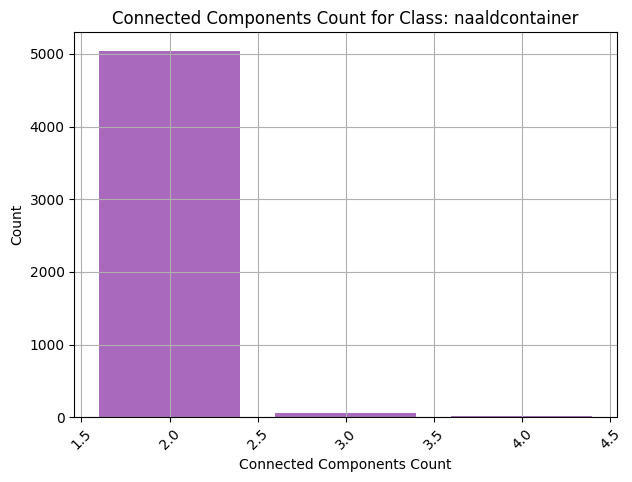

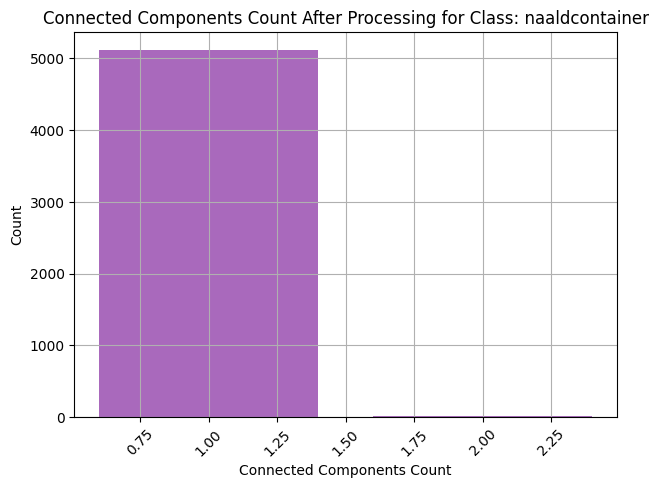

{1: 5109, 2: 12}


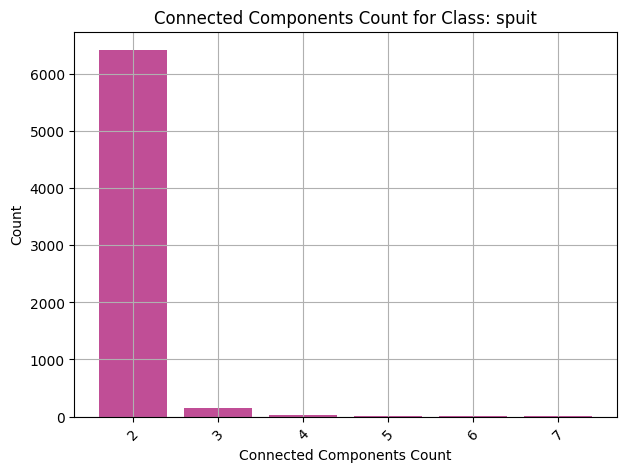

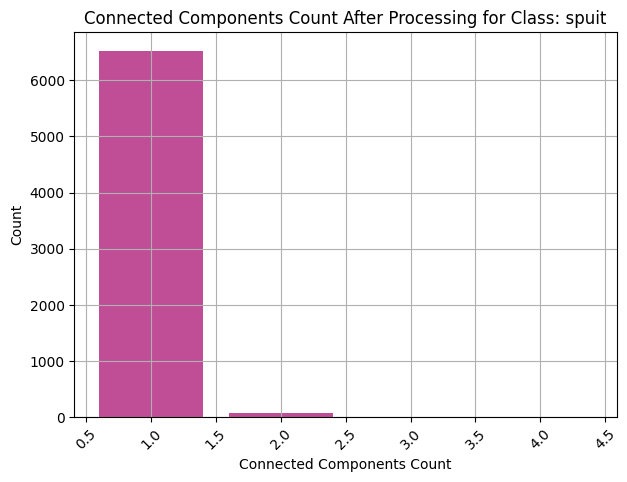

{1: 6529, 2: 84, 3: 4, 4: 1}


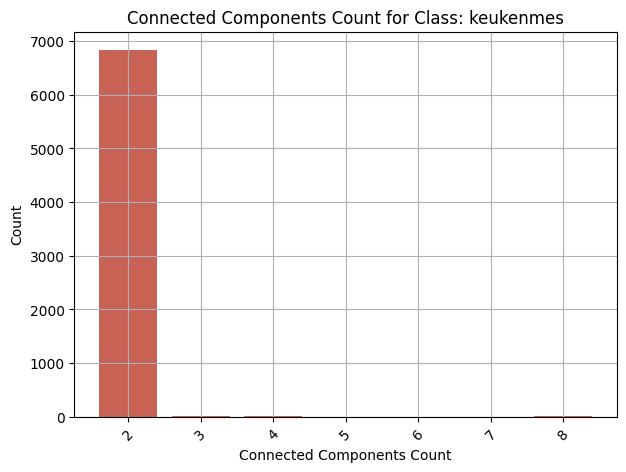

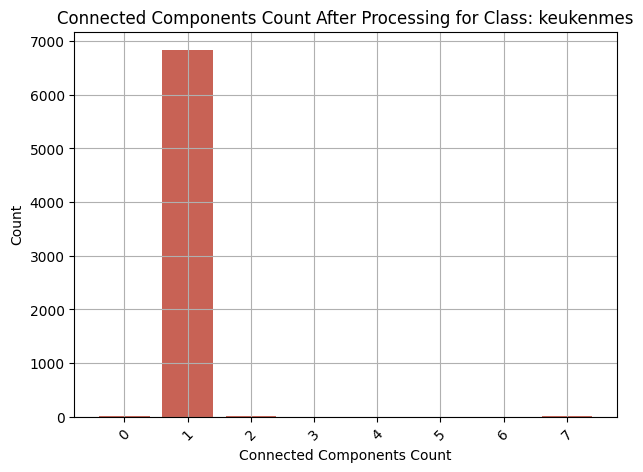

{1: 6838, 2: 5, 0: 1, 7: 1}


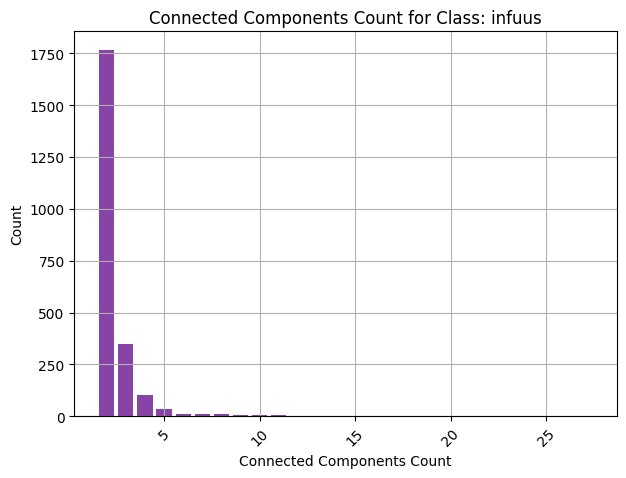

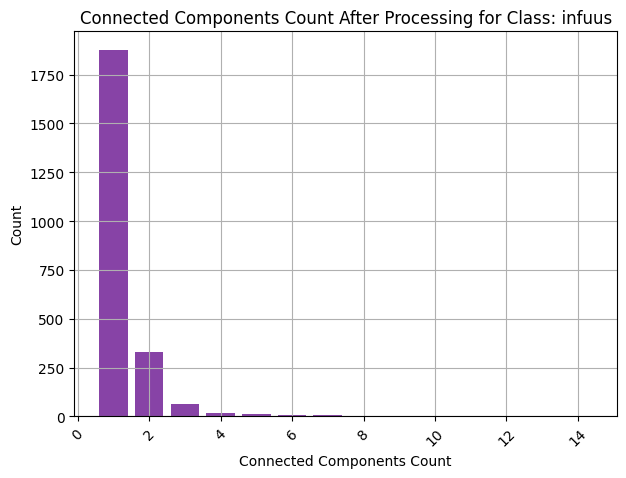

{1: 1878, 2: 332, 3: 63, 4: 15, 5: 11, 11: 3, 6: 6, 7: 6, 9: 1, 14: 1, 8: 2, 12: 1, 10: 2}


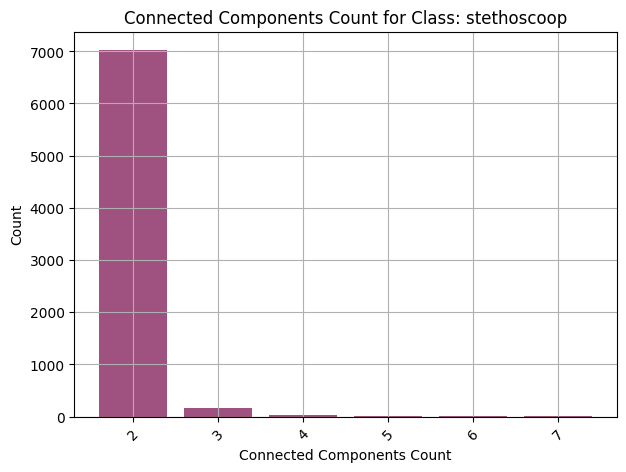

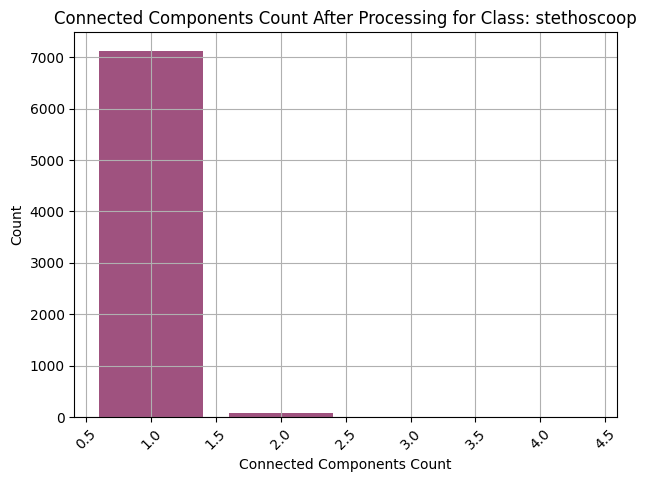

{1: 7127, 3: 7, 2: 81, 4: 4}


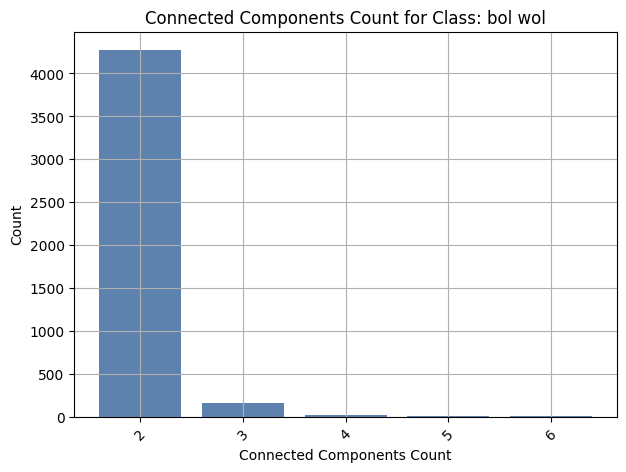

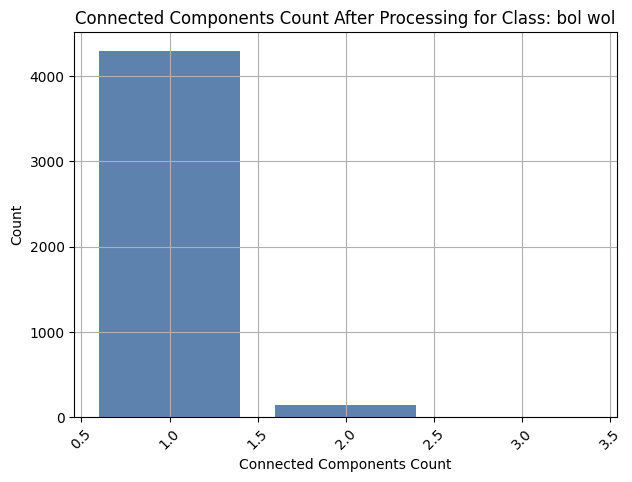

{1: 4300, 2: 142, 3: 7}


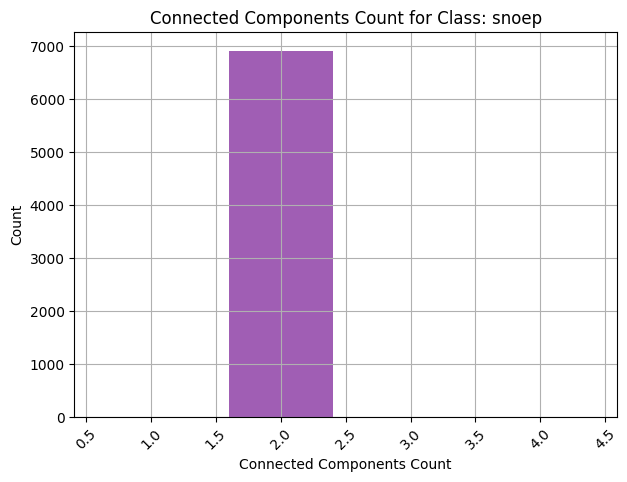

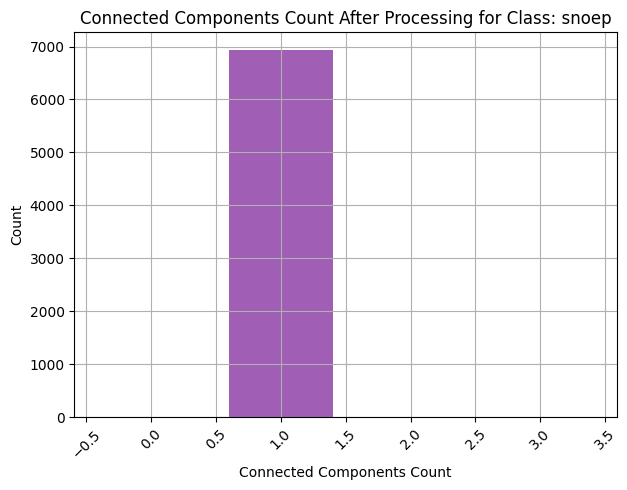

{1: 6926, 3: 2, 2: 8, 0: 1}


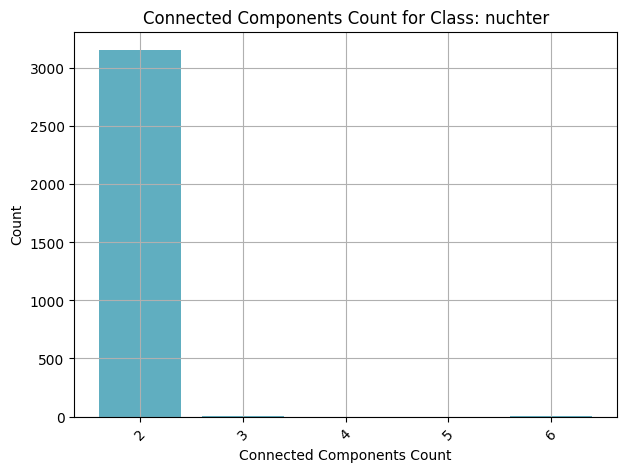

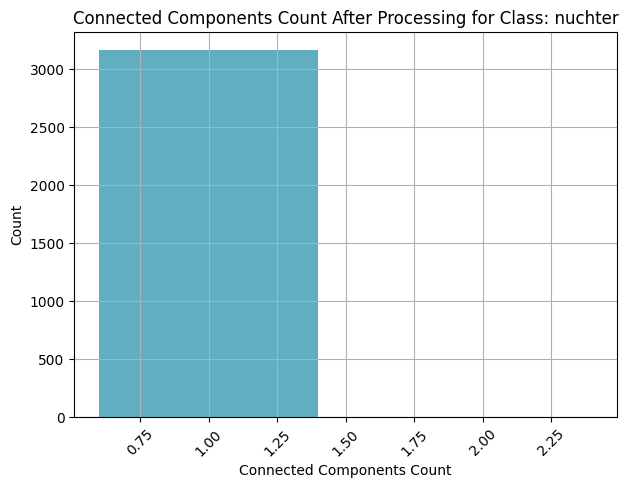

{1: 3163, 2: 1}


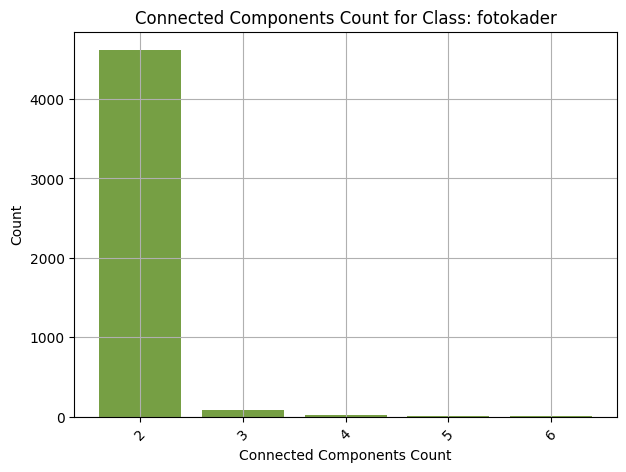

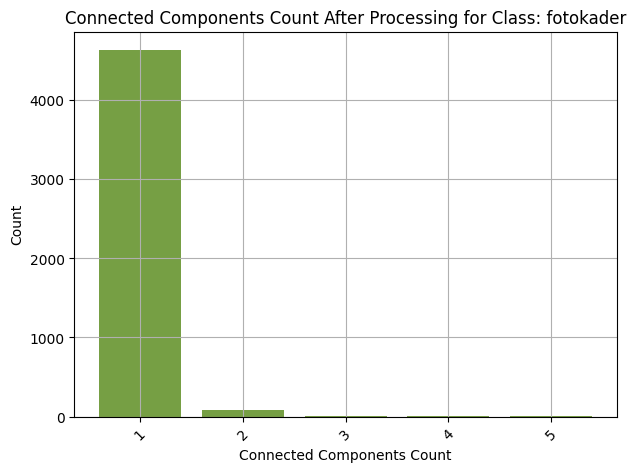

{1: 4633, 2: 80, 3: 6, 4: 2, 5: 1}


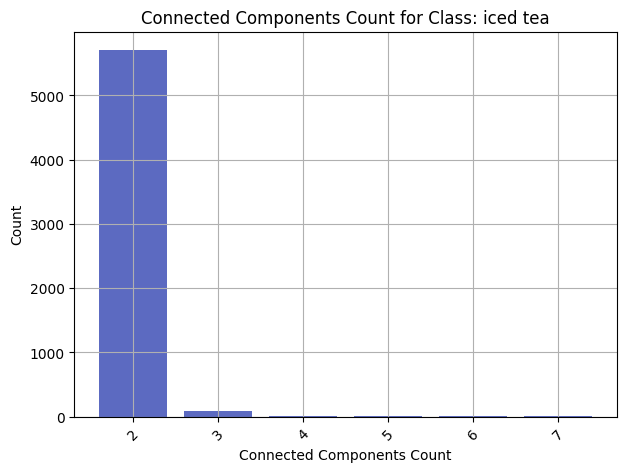

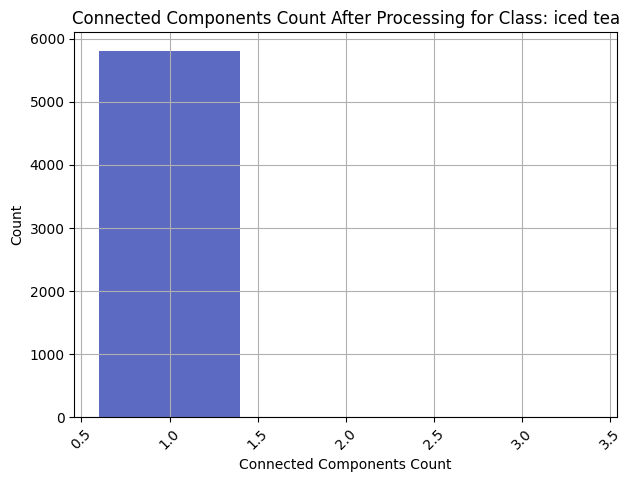

{1: 5810, 2: 11, 3: 1}


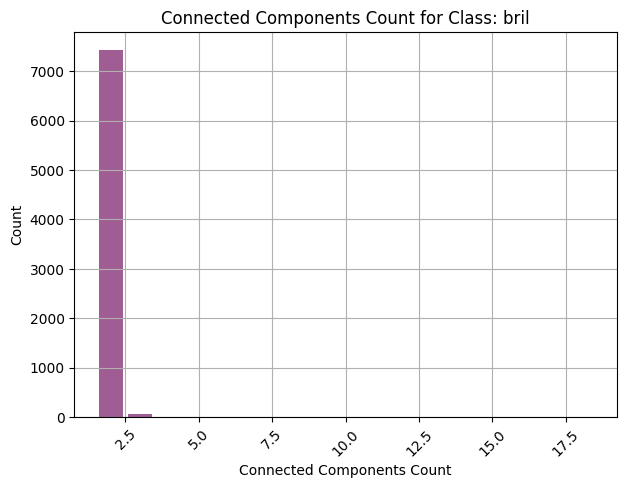

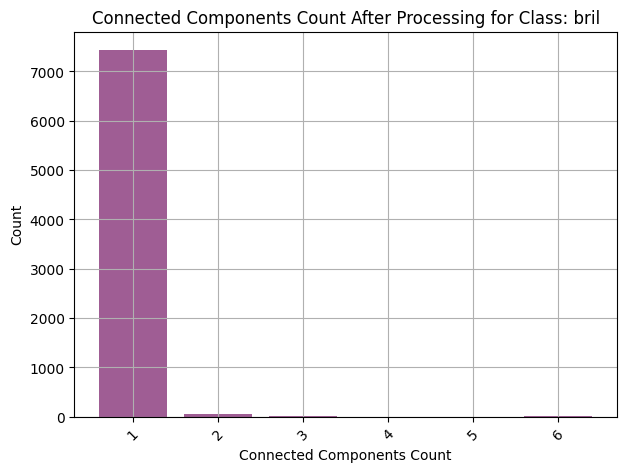

{1: 7436, 2: 56, 3: 5, 6: 1}


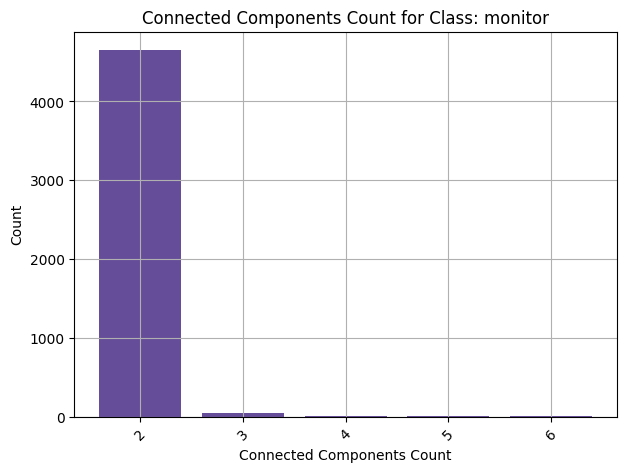

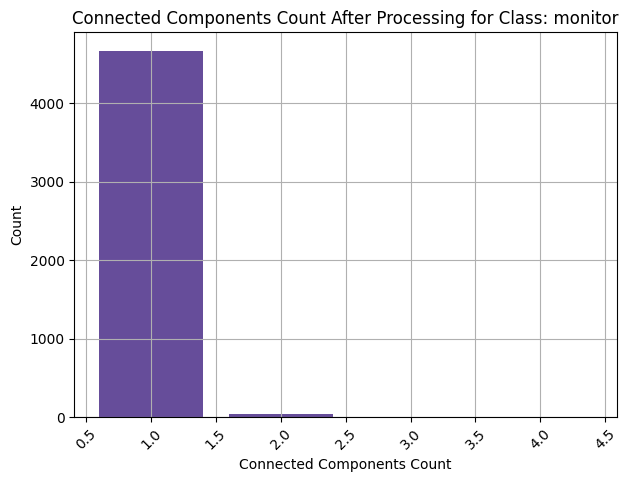

{1: 4673, 3: 7, 2: 39, 4: 4}


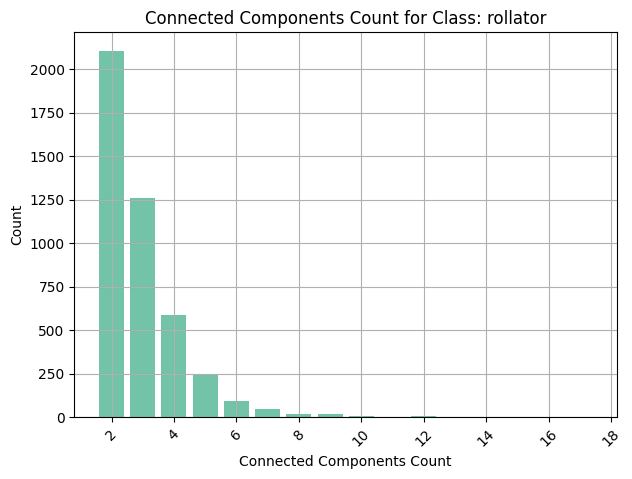

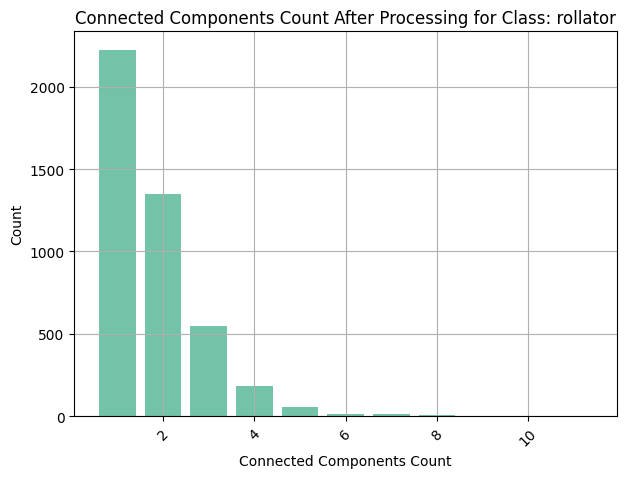

{1: 2224, 2: 1347, 3: 547, 4: 186, 5: 55, 7: 13, 6: 16, 8: 7, 10: 1, 11: 1, 9: 1}


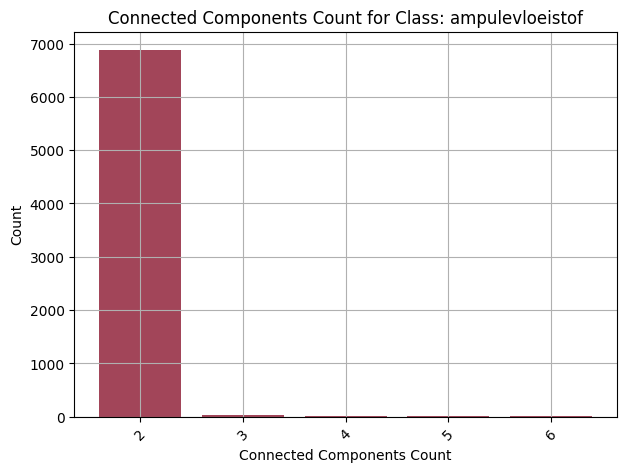

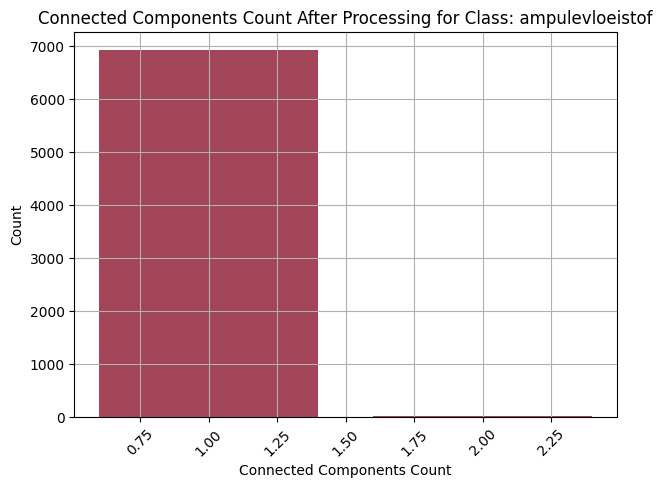

{1: 6913, 2: 12}


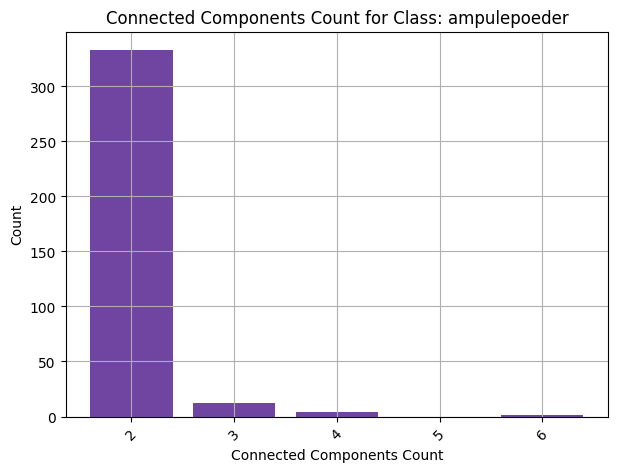

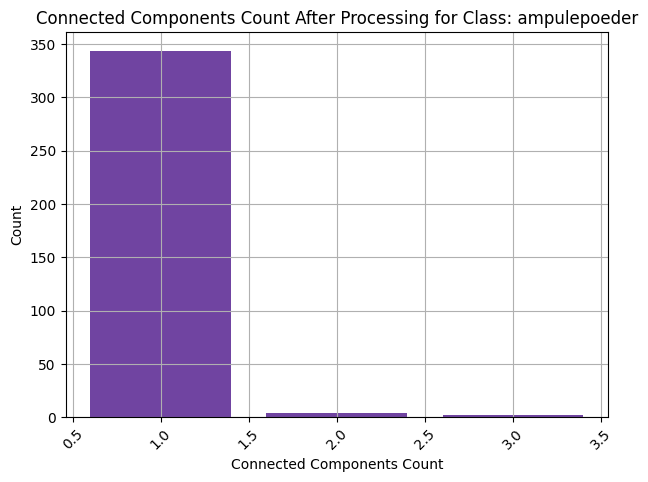

{1: 344, 2: 4, 3: 2}


In [5]:
def plot_bounding_box_fix(session: Session, labeling_recording_id: str):
    calibration_id = simrooms_repo.get_calibration_recording(
        session, simroom_id=SIMROOM_ID, recording_id=labeling_recording_id
    ).id
    tracked_classes = simrooms_repo.get_tracked_classes(session, calibration_id)

    tracking_results_per_class, _ = get_tracking_results_per_class(
        session, labeling_recording_id
    )

    connected_component_counts_per_class_before = {
        tracked_class.id: {} for tracked_class in tracked_classes
    }
    connected_component_counts_per_class_after = {
        tracked_class.id: {} for tracked_class in tracked_classes
    }

    for tracked_class in tracked_classes:
        class_id = tracked_class.id
        tracking_results = tracking_results_per_class[class_id]
        for result in tracking_results:
            file = np.load(result)
            mask = file["mask"]
            x1, y1, x2, y2 = file["box"]

            components_count = cv2.connectedComponents(
                mask[0].astype(np.uint8), connectivity=8
            )[0]
            if (
                connected_component_counts_per_class_before[class_id].get(
                    components_count
                )
                is None
            ):
                connected_component_counts_per_class_before[class_id][
                    components_count
                ] = 0

            connected_component_counts_per_class_before[class_id][components_count] += 1

            eroded_mask = cv2.erode(
                mask[0].astype(np.uint8), np.ones((3, 3), np.uint8), iterations=1
            )
            dilated_mask = cv2.dilate(
                eroded_mask, np.ones((3, 3), np.uint8), iterations=1
            )

            contours, _ = cv2.findContours(
                dilated_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
            )

            if (
                connected_component_counts_per_class_after[class_id].get(len(contours))
                is None
            ):
                connected_component_counts_per_class_after[class_id][len(contours)] = 0

            connected_component_counts_per_class_after[class_id][len(contours)] += 1

        # Plot the connected component counts
        plt.figure(figsize=(7, 5))
        plt.bar(
            connected_component_counts_per_class_before[class_id].keys(),
            connected_component_counts_per_class_before[class_id].values(),
            color=tracked_class.color,
        )
        plt.xlabel("Connected Components Count")
        plt.ylabel("Count")
        plt.title(f"Connected Components Count for Class: {CLASS_ID_TO_NAME[class_id]}")
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.show()

        # Plot the connected component counts after processing
        plt.figure(figsize=(7, 5))
        plt.bar(
            connected_component_counts_per_class_after[class_id].keys(),
            connected_component_counts_per_class_after[class_id].values(),
            color=tracked_class.color,
        )
        plt.xlabel("Connected Components Count")
        plt.ylabel("Count")
        plt.title(
            f"Connected Components Count After Processing for Class: {CLASS_ID_TO_NAME[class_id]}"
        )
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.show()

        print(connected_component_counts_per_class_after[class_id])


with Session(engine) as session:
    plot_bounding_box_fix(session, LABELING_REC_SAME_BACKGROUND_ID)
    # create_validation_video(session, LABELING_REC_DIFF_BACKGROUND_ID)

In [ ]:
def fix_mask_and_box(file) -> tuple[np.ndarray, np.ndarray]:
    x1, y1, x2, y2 = file["box"]
    mask = file["mask"]

    eroded_mask = cv2.erode(
        mask[0].astype(np.uint8), np.ones((3, 3), np.uint8), iterations=1
    )
    mask = cv2.dilate(eroded_mask, np.ones((3, 3), np.uint8), iterations=1)
    mask_torch = torch.from_numpy(mask).unsqueeze(0)

    # create empty 1920x1080 tensor
    full_mask = torch.zeros((1, 1080, 1920), dtype=torch.uint8)
    full_mask[:, y1:y2, x1:x2] = mask_torch

    if full_mask.sum() == 0:
        return np.zeros((1, 1, 1), dtype=np.uint8), np.array([0, 0, 0, 0])

    boxes = masks_to_boxes(full_mask)
    x1, y1, x2, y2 = boxes[0].int().tolist()
    mask = full_mask[0, y1:y2, x1:x2].unsqueeze(0).numpy()

    return mask, np.array([x1, y1, x2, y2])


def filter_and_fix_tracking_results(session: Session, labeling_recording_id: str):
    calibration_id = simrooms_repo.get_calibration_recording(
        session, simroom_id=SIMROOM_ID, recording_id=labeling_recording_id
    ).id
    tracked_classes = simrooms_repo.get_tracked_classes(session, calibration_id)

    tracking_results_per_class, _ = get_tracking_results_per_class(
        session, labeling_recording_id
    )

    # for each class, postprocess the tracking results
    for tracked_class in tracked_classes:
        class_id = tracked_class.id
        tracking_results = tracking_results_per_class[class_id]

        for result in tqdm(tracking_results):
            parts = result.parts
            idx = parts.index("labeling_results")
            result_subpath = Path(*parts[idx + 1 :])
            target_path = PROCESSED_TRACKING_RESULTS_PATH / str(result_subpath)

            file = np.load(result)

            # 1. fix the mask and box
            mask, box = fix_mask_and_box(file)
            x1, y1, x2, y2 = box

            # 2. ignore result if the box is smaller than 10x10 (based on area)
            area = (x2 - x1) * (y2 - y1)
            if area < 100:
                continue

            # 3. ignore result if the mask is empty
            if np.sum(mask) == 0:
                continue

            # Save the fixed result
            if not target_path.parent.exists():
                target_path.parent.mkdir(parents=True, exist_ok=True)

            if len(file.files) != 5:
                raise ValueError(f"Expected 5 files but got {len(file.files)}")

            # calculate variance of the laplacian on the ROI of this sample
            roi = file["roi"]
            laplacian_variance = cv2.Laplacian(roi, cv2.CV_64F).var()

            np.savez_compressed(
                target_path,
                mask=mask,
                box=box,
                roi=file["roi"],
                class_id=file["class_id"],
                frame_idx=file["frame_idx"],
                laplacian_variance=laplacian_variance,
            )


if PROCESSED_TRACKING_RESULTS_PATH.exists():
    shutil.rmtree(PROCESSED_TRACKING_RESULTS_PATH)
PROCESSED_TRACKING_RESULTS_PATH.mkdir(parents=True, exist_ok=True)

with Session(engine) as session:
    filter_and_fix_tracking_results(session, LABELING_REC_SAME_BACKGROUND_ID)
    # create_validation_video(session, LABELING_REC_DIFF_BACKGROUND_ID)

100%|██████████| 350/350 [00:02<00:00, 171.99it/s]


: 

: 